In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import scipy
from scipy.optimize import curve_fit
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
sys.path.append('../')
import fn

/Users/cutterdawes/Desktop/Princeton/Thesis/Repo/ml/../fn.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
%load_ext autoreload
%autoreload 2

## Testing results locally

In [ ]:
import addition_data
import addition_eval
from LSTM import LSTM
import time

In [28]:
with open('../pickles/carry_tables/all_tables_d1_b2-6.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [21]:
b = 5
tables = all_tables[b]

In [22]:
table = tables[((0,)*b,)*b]

In [23]:
training_dataloader, testing_dataloader = addition_data.prepare(b, 6, table, batch_size=125, split_type='OOD', split_depth=3, sample=True)

In [24]:
model = LSTM(b, 1)
loss, training_acc, testing_acc = addition_eval.eval(
    model, training_dataloader, testing_dataloader, lr=0.05,
    num_passes=1000, log_interval=10, print_loss_and_acc=True
)

t = 0
loss = 1.542451, training_acc = 0.000, testing_acc = 0.000



KeyboardInterrupt: 

In [ ]:
for lr, testing_acc in test_acc_vs_lr.items():
    plt.plot(testing_acc, alpha=0.5, label=lr)
plt.legend()

For b=3, lr=0.02,0.04 achieved fastest results (w/ batch_size=16)

For b=4, lr=0.04 achieved fastest results (w/ batch_size=64)


Seems like batch_size=16 is sweet spot for base 3, and batch_size=64 is sweet spot for base 4, 5

## Plot Learning Speeds

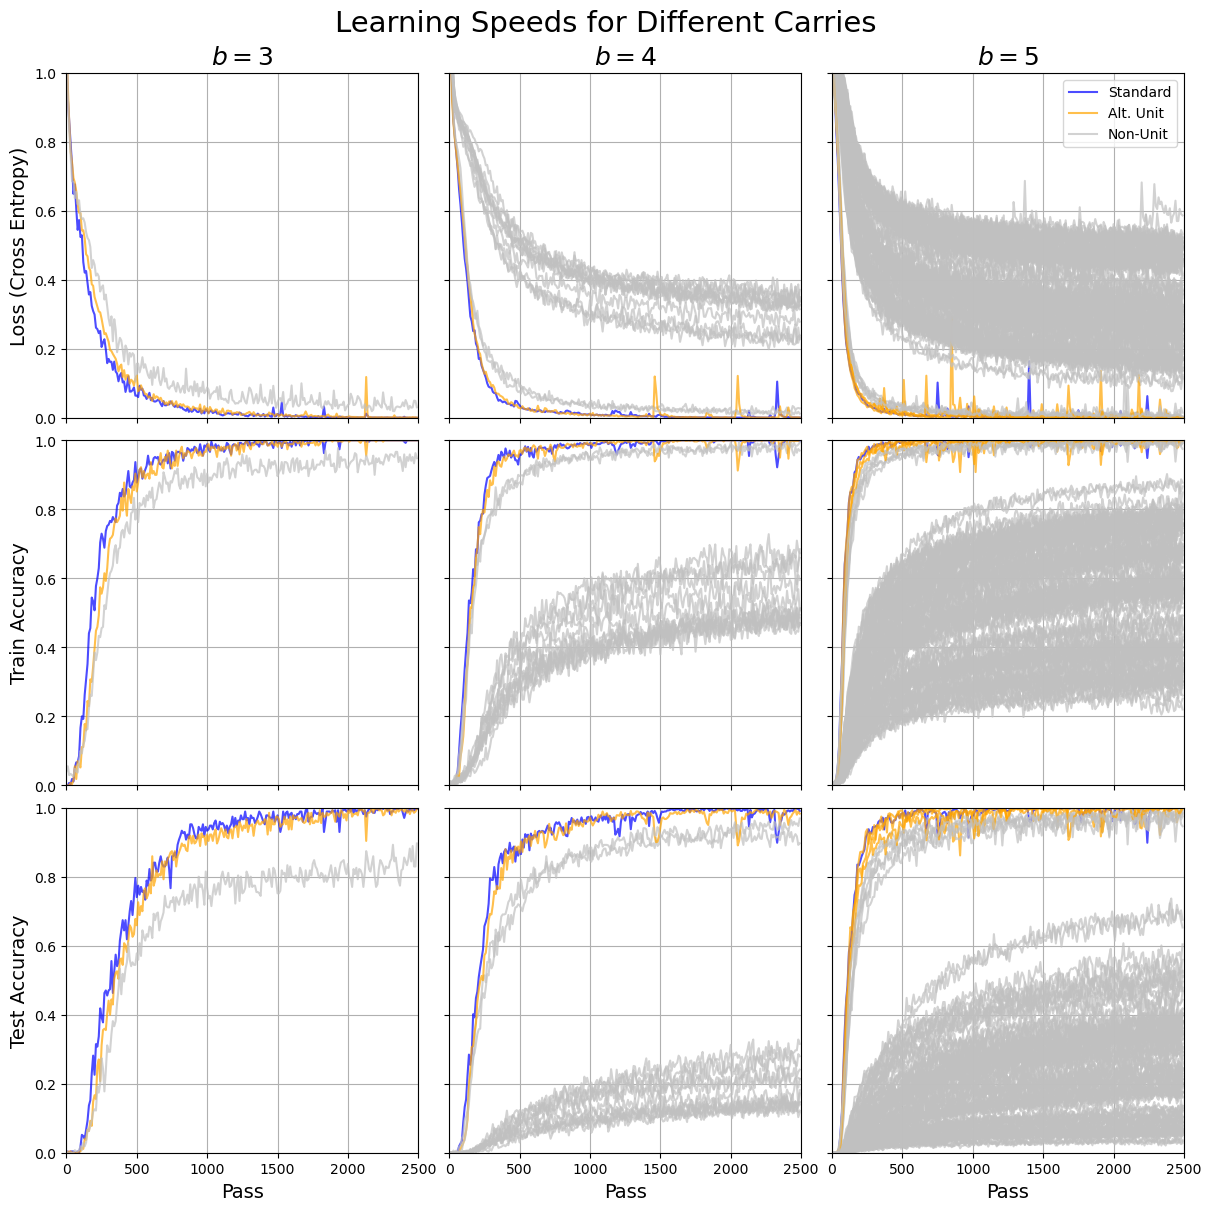

In [66]:
# create subplots, title figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning Speeds for Different Carries', fontsize=21)

for i in range(3):
    for j in range(3):

        # get b, learning speeds
        b = i + 3
        with open(f'../pickles/learning_metrics/learning_metrics{b}_10trials.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 250)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))

        # loss plot
        if j == 0:
            ax.set_title(f'$b = {b}$', fontsize=18)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                if (np.array(dc) == 0).all():
                    std, = ax.plot(loss, color='blue', alpha=0.7, label='Standard')
                elif len(np.unique(all_tables[b][dc])) == 2:
                    alt_unit, = ax.plot(loss, color='orange', alpha=0.7, label='Alt. Unit')
                else:
                    other, = ax.plot(loss, color='silver', alpha=0.7, label='Non-Unit')
            if i == 0:
                ax.set_ylabel('Loss (Cross Entropy)', fontsize=14)
            elif i == 2:
                ax.legend(handles=[std, alt_unit, other])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                if (np.array(dc) == 0).all():
                    ax.plot(train_acc, color='blue', alpha=0.7, label='Standard')
                elif len(np.unique(all_tables[b][dc])) == 2:
                    ax.plot(train_acc, color='orange', alpha=0.7, label='Alt. Unit')
                else:
                    ax.plot(train_acc, color='silver', alpha=0.7, label='Non-Unit')
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=14)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                if (np.array(dc) == 0).all():
                    ax.plot(test_acc, color='blue', alpha=0.7, label='Standard')
                elif len(np.unique(all_tables[b][dc])) == 2:
                    ax.plot(test_acc, color='orange', alpha=0.7, label='Alt. Unit')
                else:
                    ax.plot(test_acc, color='silver', alpha=0.7, label='Non-Unit')
            ax.set_xlabel('Pass', fontsize=14)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=14)
    plt.savefig('../figures/learning_speeds.png', dpi=300)

## Correlate Metrics

### Fit sigmoid function to accuracy curves

In [29]:
def acc(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

In [30]:
base = 5
with open(f'../pickles/learning_metrics/learning_metrics{base}_10trials.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

In [31]:
best_dc = -1
min_err = math.inf
for dc in learning_metrics.keys():
    x = np.arange(250)
    y = learning_metrics[dc]['testing_acc']
    try:
        (a, b, c), cov = curve_fit(acc, x, y)
    except:
        continue
    err = np.sum(np.abs((y - acc(x, a, b, c))))
    if (err < min_err) and (np.max(y) > 0.8):
        min_err = err
        best_dc = dc

/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_18941/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [32]:
y = learning_metrics[best_dc]['testing_acc']
(a, b, c), cov = curve_fit(acc, x, y)

In [33]:
print(best_dc)

((0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0), (0, 0, 0, 0, 0))


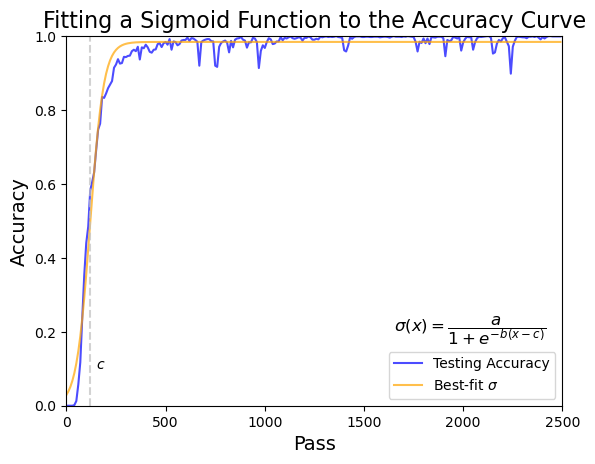

In [34]:
plt.plot(y, color='blue', alpha=0.7, label='Testing Accuracy')
plt.plot(acc(x, a, b, c), color='orange', alpha=0.7, label=r'Best-fit $\sigma$')
plt.axvline(c, color='silver', alpha=0.7, linestyle='--')
plt.text(c+3, 0.1, '$c$')
plt.text(165, 0.2, r'$\sigma(x) = \dfrac{a}{1+e^{-b(x-c)}}$', fontsize=12)
plt.legend()
# plt.grid(True)
plt.xlim(0, 250)
plt.ylim(0, 1)
plt.xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))
plt.xlabel('Pass', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Fitting a Sigmoid Function to the Accuracy Curve', fontsize=16)
plt.savefig('../figures/sigmoid_fit.png', dpi=300)

### Get all metrics

In [35]:
with open('../pickles/complexity_measures/est_dim_box_vs_depth.pickle', 'rb') as f:
    est_dim_box_vs_depth = pickle.load(f)

In [36]:
with open('../pickles/complexity_measures/associativity_d6.pickle', 'rb') as f:
    all_associativity = pickle.load(f)

In [37]:
with open('../pickles/complexity_measures/frac_zeros_vs_depth.pickle', 'rb') as f:
    all_frac_zeros = pickle.load(f)

In [38]:
with open('../pickles/complexity_measures/num_digits_vs_depth.pickle', 'rb') as f:
    all_num_digits = pickle.load(f)

In [39]:
all_est_dims = {}
all_critical_pts = {}

for base in range(3, 6):
    x = np.arange(250)
    with open(f'../pickles/learning_metrics/learning_metrics{base}_10trials.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    est_dims = [est_dim_box_vs_depth[base][dc][3] for dc in all_tables[base].keys()]
    critical_pts = []
    for dc in all_tables[base].keys():
        y = learning_metrics[dc]['testing_acc']
        try:
            (a, b, c), cov = curve_fit(acc, x, y)
        except:
            c = -1
        critical_pts.append(c)
    all_est_dims[base] = est_dims
    all_critical_pts[base] = critical_pts

/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_18941/4099419075.py:2: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c)))


In [40]:
valid = lambda x: x > 0
for b in range(3, 6):
    critical_pts = all_critical_pts[b]
    est_dims = all_est_dims[b]
    associativity = list(all_associativity[b].values())
    frac_zeros = [all_frac_zeros[b][dc][0] for dc in all_tables[b].keys()]
    num_digits = [all_num_digits[b][dc][0] for dc in all_tables[b].keys()]
    valid_tuples = [(crit_pt, est_dim, frac_assoc, frac_zero, num_digit) for crit_pt, est_dim, frac_assoc, frac_zero, num_digit
                    in zip(critical_pts, est_dims, associativity, frac_zeros, num_digits) if valid(crit_pt)]
    critical_pts = [crit_pt for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    est_dims = [est_dim for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    associativity = [frac_assoc for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    frac_zeros = [frac_zero for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    num_digits = [num_digit for crit_pt, est_dim, frac_assoc, frac_zero, num_digit in valid_tuples]
    all_critical_pts[b] = critical_pts
    all_est_dims[b] = est_dims
    all_associativity[b] = associativity
    all_frac_zeros[b] = frac_zeros
    all_num_digits[b] = num_digits

In [41]:
associativity_flat = []
est_dims_flat = []
critical_pts_flat = []
frac_zeros_flat = []
num_digits_flat = []
for b in all_est_dims.keys():
    est_dims_flat += all_est_dims[b]
    critical_pts_flat += all_critical_pts[b]
    associativity_flat += all_associativity[b]
    frac_zeros_flat += all_frac_zeros[b]
    num_digits_flat += all_num_digits[b]

### Correlate box-counting dim with learning Speed

**HOW TO CORRELATE WITH MULTIPLE SAMPLES**

In [42]:
r = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(est_dims_flat, critical_pts_flat).pvalue

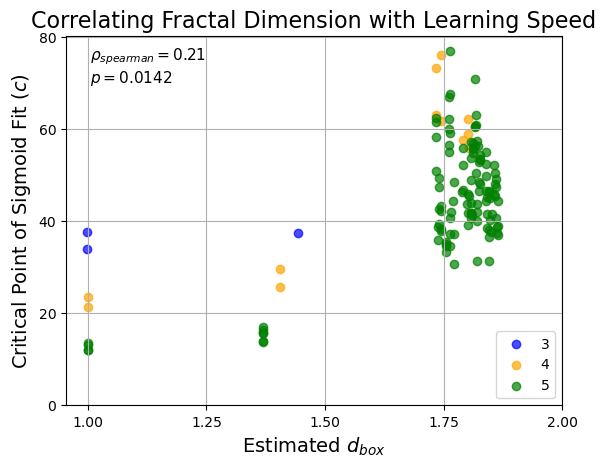

In [44]:
plt.scatter(all_est_dims[3], all_critical_pts[3], alpha=0.7, color='blue', label=3)
plt.scatter(all_est_dims[4], all_critical_pts[4], alpha=0.7, color='orange', label=4)
plt.scatter(all_est_dims[5], all_critical_pts[5], alpha=0.7, color='green', label=5)
plt.legend(loc = 'lower right')
text = r'$\rho_{spearman} =$' + str(round(r, 2)) + '\n' + r'$p =$' + str(round(p, 4))
plt.text(1.004, 70, text, fontsize=11)
plt.xticks(np.linspace(1, 2, 5))
plt.yticks(np.linspace(0, 80, 5))
plt.grid(True)
plt.xlabel('Estimated '+r'$d_{box}$', fontsize=14)
plt.ylabel('Critical Point of Sigmoid Fit ($c$)', fontsize=14)
plt.title('Correlating Fractal Dimension with Learning Speed', fontsize=16)
plt.savefig('../figures/correlation_dim_box.png', dpi=300)

### Correlate associativity fraction with learning Speed

In [136]:
r = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(associativity_flat, critical_pts_flat).pvalue

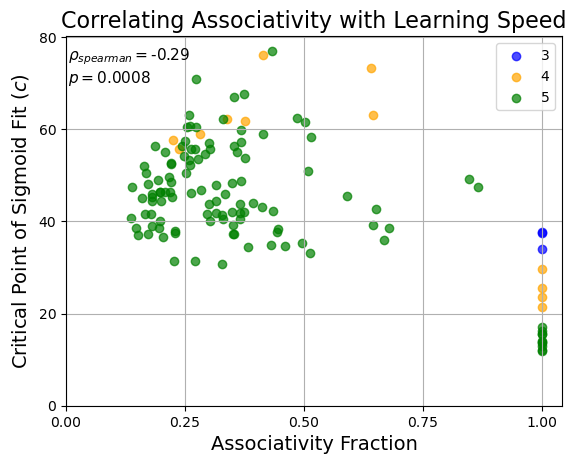

In [137]:
plt.scatter(all_associativity[3], all_critical_pts[3], alpha=0.7, color='blue', label=3)
plt.scatter(all_associativity[4], all_critical_pts[4], alpha=0.7, color='orange', label=4)
plt.scatter(all_associativity[5], all_critical_pts[5], alpha=0.7, color='green', label=5)
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + str(round(r, 2)) + '\n' + r'$p =$' + str(round(p, 4))
plt.text(0.004, 70, text, fontsize=11)
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, 80, 5))
plt.grid(True)
plt.xlabel('Associativity Fraction', fontsize=14)
plt.ylabel('Critical Point of Sigmoid Fit ($c$)', fontsize=14)
plt.title('Correlating Associativity with Learning Speed', fontsize=16)
plt.savefig('../figures/correlation_associativity.png', dpi=300)

### Correlate with Frequency of Carrying

In [142]:
r = scipy.stats.spearmanr(frac_zeros_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(frac_zeros_flat, critical_pts_flat).pvalue

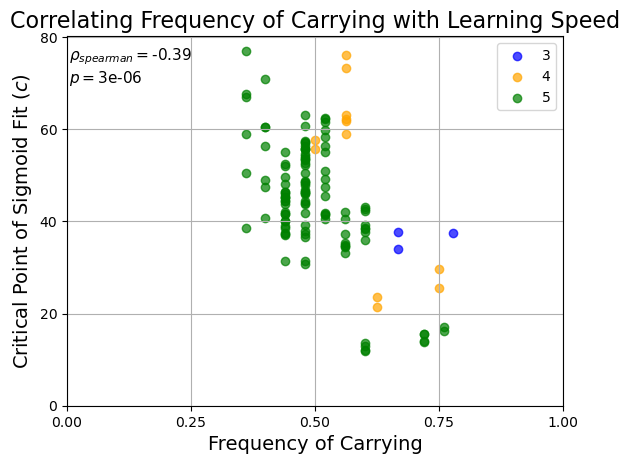

In [143]:
plt.scatter(all_frac_zeros[3], all_critical_pts[3], alpha=0.7, color='blue', label=3)
plt.scatter(all_frac_zeros[4], all_critical_pts[4], alpha=0.7, color='orange', label=4)
plt.scatter(all_frac_zeros[5], all_critical_pts[5], alpha=0.7, color='green', label=5)
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + str(round(r, 2)) + '\n' + r'$p =$' + str(round(p, 6))
plt.text(0.004, 70, text, fontsize=11)
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, 80, 5))
plt.grid(True)
plt.xlabel('Frequency of Carrying', fontsize=14)
plt.ylabel('Critical Point of Sigmoid Fit ($c$)', fontsize=14)
plt.title('Correlating Frequency of Carrying with Learning Speed', fontsize=16)
plt.savefig('../figures/correlation_carry_freq.png', dpi=300)

### Correlate with Number of Unique Carries

In [140]:
r = scipy.stats.spearmanr(num_digits_flat, critical_pts_flat).statistic
p = scipy.stats.spearmanr(num_digits_flat, critical_pts_flat).pvalue

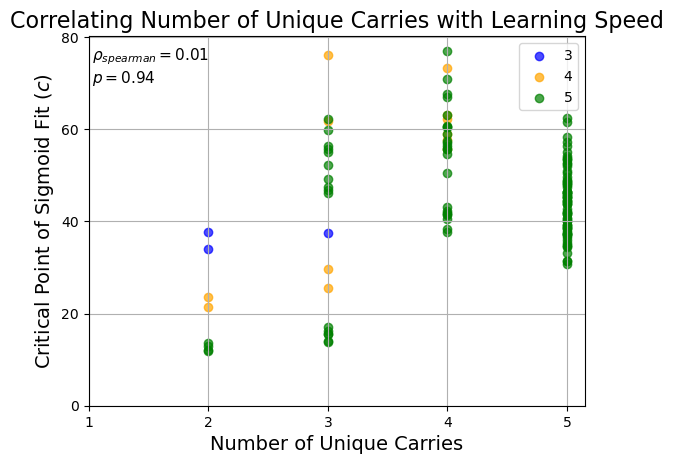

In [141]:
plt.scatter(all_num_digits[3], all_critical_pts[3], alpha=0.7, color='blue', label=3)
plt.scatter(all_num_digits[4], all_critical_pts[4], alpha=0.7, color='orange', label=4)
plt.scatter(all_num_digits[5], all_critical_pts[5], alpha=0.7, color='green', label=5)
plt.legend(loc = 'upper right')
text = r'$\rho_{spearman} =$' + str(round(r, 2)) + '\n' + r'$p =$' + str(round(p, 2))
plt.text(1.025, 70, text, fontsize=11)
plt.xticks(np.linspace(1, 5, 5))
plt.yticks(np.linspace(0, 80, 5))
plt.grid(True)
plt.xlabel('Number of Unique Carries', fontsize=14)
plt.ylabel('Critical Point of Sigmoid Fit ($c$)', fontsize=14)
plt.title('Correlating Number of Unique Carries with Learning Speed', fontsize=16)
plt.savefig('../figures/correlation_num_carries.png', dpi=300)

## Adding and Shuffling Digit Ordering

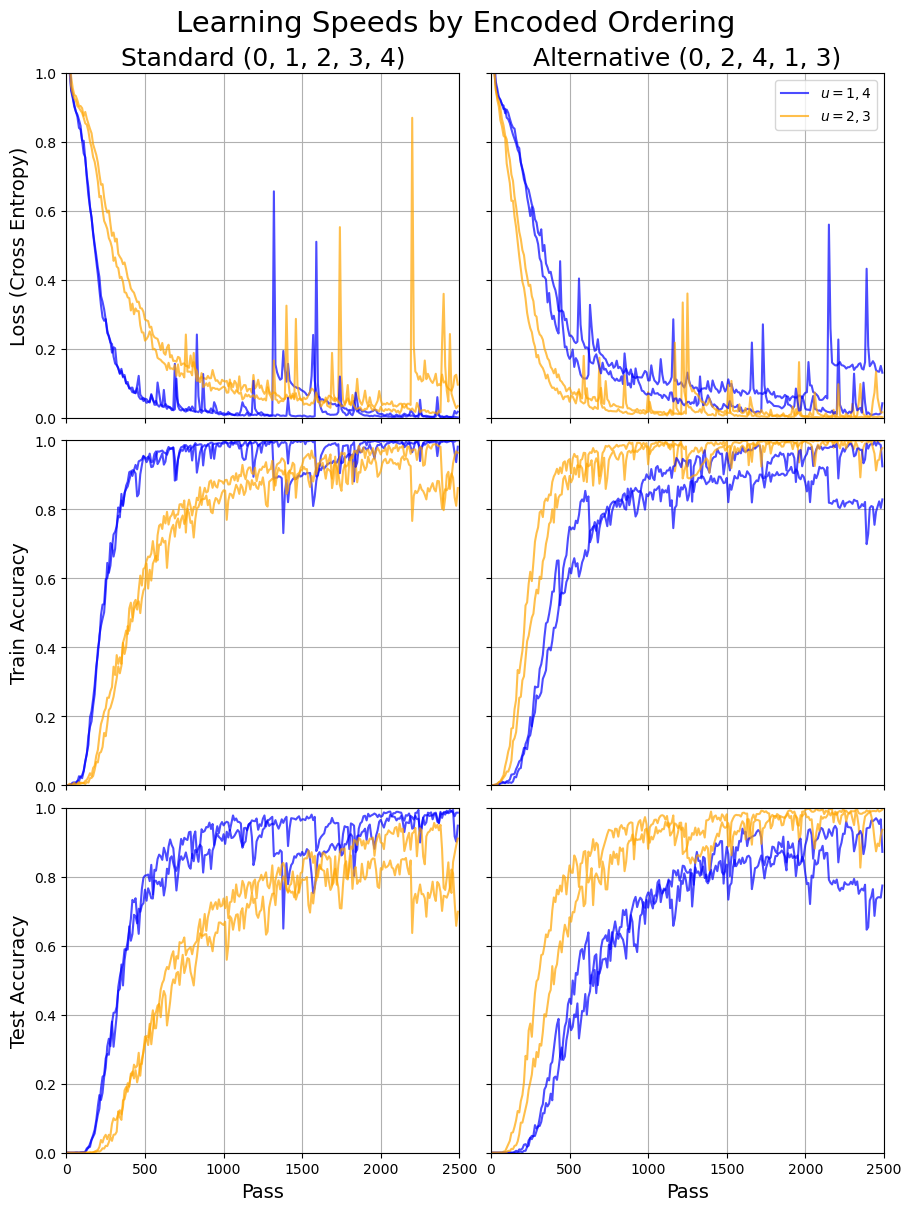

In [83]:
# create subplots, title figure
fig, axes = plt.subplots(3, 2, figsize=(9, 12), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Learning Speeds by Encoded Ordering', fontsize=21)

b = 5
for i in range(2):
    for j in range(3):

        # get b, learning Speeds
        u = i + 1
        with open(f'../pickles/learning_metrics/learning_metrics5_semantic{u}.pickle', 'rb') as f:
            learning_metrics = pickle.load(f)

        # get ax, set basic formatting
        ax = axes[j, i]
        ax.grid(True)
        ax.set_xlim(0, 250)
        ax.set_ylim(0)
        ax.set_xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))

        # loss plot
        if j == 0:
            if i == 0:
                ax.set_title('Standard (0, 1, 2, 3, 4)', fontsize=18)
            if i == 1:
                ax.set_title('Alternative (0, 2, 4, 1, 3)', fontsize=18)
            for dc in learning_metrics.keys():
                loss = learning_metrics[dc]['loss']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    std, = ax.plot(loss, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    alt, = ax.plot(loss, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Loss (Cross Entropy)', fontsize=14)
            elif i == 1:
                ax.legend(handles=[std, alt])
    
        # training accuracy plot
        if j == 1:
            for dc in learning_metrics.keys():
                train_acc = learning_metrics[dc]['training_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(train_acc, color='blue', alpha=0.7, label='$u=1$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(train_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            if i == 0:
                ax.set_ylabel('Train Accuracy', fontsize=14)
    
        # testing accuracy plot
        if j == 2:
            for dc in learning_metrics.keys():
                test_acc = learning_metrics[dc]['testing_acc']
                if np.unique(all_tables[b][dc])[1] in [1, 4]:
                    ax.plot(test_acc, color='blue', alpha=0.7, label='$u=1, 4$')
                elif np.unique(all_tables[b][dc])[1] in [2, 3]:
                    ax.plot(test_acc, color='orange', alpha=0.7, label='$u=2, 3$')
            ax.set_xlabel('Pass', fontsize=14)
            if i == 0:
                ax.set_ylabel('Test Accuracy', fontsize=14)
    plt.savefig('../figures/learning_speeds_ordering.png', dpi=300)